In [102]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sea
import yellowbrick as yel
from yellowbrick.features import Manifold

In [63]:
file_name = "breast-cancer-wisconsin-data.csv"

df = pd.read_csv(file_name)
df=df.drop(columns=['Unnamed: 32']) #There's some weird dummy column showing up that's all nan values (probably has something to do the delimiter reading)
df=df.dropna() #clean nan values from the getgo
df.diagnosis = pd.Series(np.where(df.diagnosis.values == 'M', 1, 0), df.index) #Change diagnosis identifiers to 1==M and 0==B for ease of fit and score
X=df.values[:,2:]
y=df.values[:,1]

Percent Accuracy: 99.12280701754386


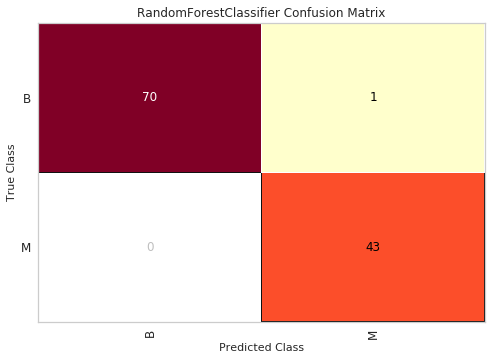

In [100]:
test_size = 0.2
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size)
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
result_test_train = model.score(X_test, y_test)
print("Percent Accuracy: %s" % (result_test_train*100.0))

cancer_cm = yel.classifier.ConfusionMatrix(model, classes=['B','M'], label_encoder={0: 'B', 1: 'M'})
cancer_cm.fit(X_train, y_train)
cancer_cm.score(X_test, y_test)

cancer_cm.show(outpath="confusion_matrix_resamp.png",bbox="tight")

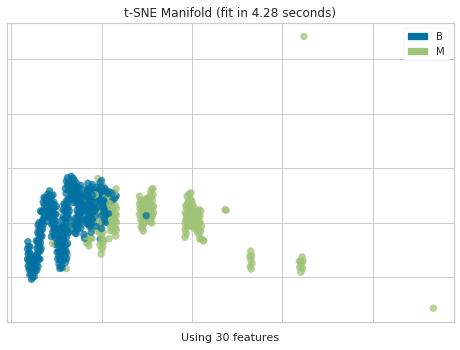

In [137]:
viz = Manifold(manifold="tsne", classes=['B','M'], label_encoder={0: 'B', 1: 'M'})

viz.fit_transform(df.loc[:, 'radius_mean':], df['diagnosis'])  # Fit the data to the visualizer
viz.show(outpath="manifold_resamp.png",bbox="tight")  

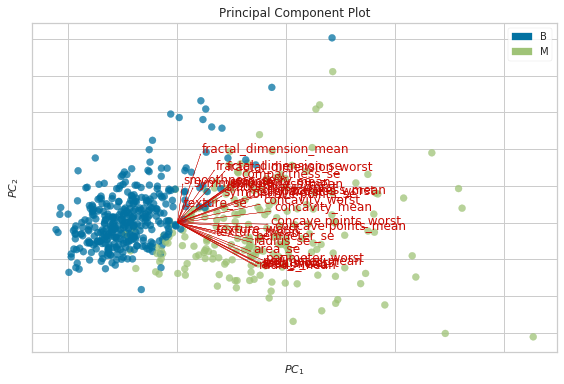

In [138]:
from yellowbrick.features.pca import PCADecomposition

visualizer = PCADecomposition(scale=True, proj_features=True, proj_dim=3,classes=['B','M'], label_encoder={0: 'B', 1: 'M'})
visualizer.fit_transform(df.loc[:, 'radius_mean':], df['diagnosis'])
visualizer.show(outpath="pcplot_resamp.png",bbox="tight")

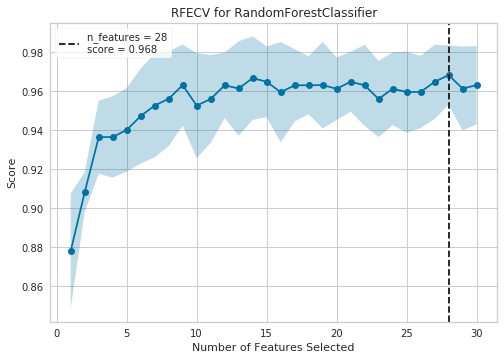

In [145]:
from yellowbrick.model_selection import RFECV

cv = model_selection.StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(n_estimators=100), cv=cv, scoring='f1_weighted')

visualizer.fit(df.loc[:, 'radius_mean':], df['diagnosis'])        # Fit the data to the visualizer
visualizer.show(outpath="recursive_feature_elim_resamp.png",bbox="tight")           # Finalize and render the figure

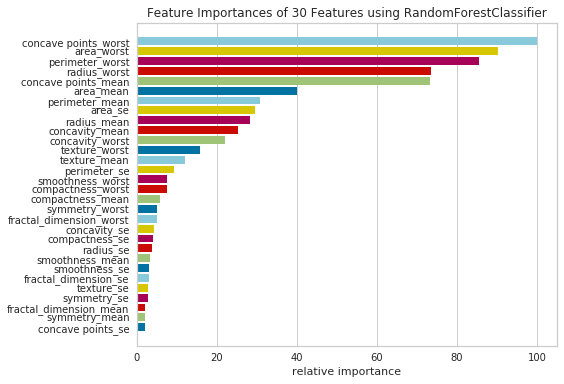

In [141]:
from yellowbrick.model_selection import FeatureImportances


model = RandomForestClassifier(n_estimators=100)
viz = FeatureImportances(model)
viz.fit(df.loc[:, 'radius_mean':], df['diagnosis'])
viz.show(outpath="feature_importances_resamp.png",bbox="tight")

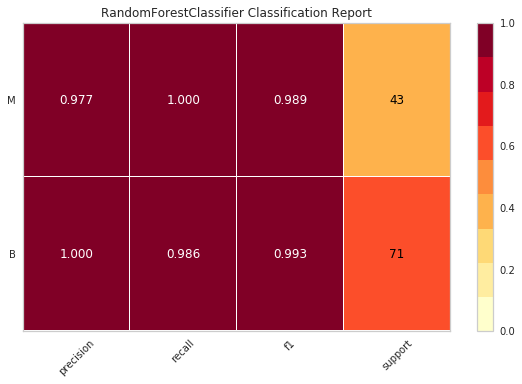

In [142]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
model = RandomForestClassifier(n_estimators=100)
visualizer = ClassificationReport(model, classes=['B','M'], label_encoder={0: 'B', 1: 'M'}, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show(outpath="classification_report_resamp.png",bbox="tight")

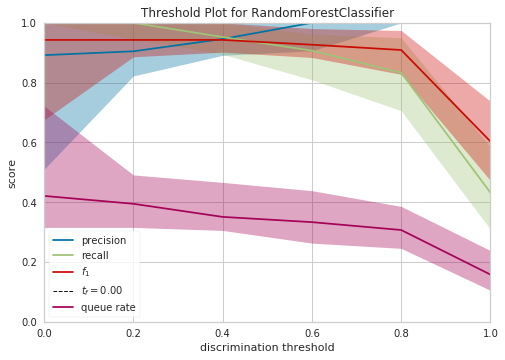

In [143]:
from yellowbrick.classifier import DiscriminationThreshold

# Instantiate the classification model and visualizer
visualizer = DiscriminationThreshold(model)

visualizer.fit(df.loc[:, 'radius_mean':], df['diagnosis'])        # Fit the data to the visualizer
visualizer.show(outpath="discrimination_threshold_resamp.png",bbox="tight")  

In [67]:
loo = model_selection.LeaveOneOut()
model = RandomForestClassifier(n_estimators=100)
result_LOO = model_selection.cross_val_score(model, X, y, cv=loo)
print("Percent Accuracy: %s (+/- %s)" % (result_LOO.mean()*100.0, result_LOO.std()*100.0))

Percent Accuracy: 96.30931458699473 (+/- 18.853312241692635)


In [68]:
kfold = model_selection.KFold(n_splits=100)
model = RandomForestClassifier(n_estimators=100)
result_kfold = model_selection.cross_val_score(model, X, y, cv=kfold)
print("Percent Accuracy: %s (+/- %s)" % (result_kfold.mean()*100.0, result_kfold.std()*100.0))

Percent Accuracy: 96.23333333333333 (+/- 8.852557696947121)


In [69]:
shuffsplit = model_selection.ShuffleSplit(n_splits=1000, test_size=test_size)
model = RandomForestClassifier(n_estimators=100)
result_shuffsplit = model_selection.cross_val_score(model, X, y, cv=shuffsplit)
print("Percent Accuracy: %s (+/- %s)" % (result_shuffsplit.mean()*100.0, result_shuffsplit.std()*100.0))

Percent Accuracy: 96.00877192982456 (+/- 1.744599899364971)


1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621
631
641
651
661
671
681
691
701
711
721
731
741
751
761
771
781
791
801
811
821
831
841
851
861
871
881
891
901
911
921
931
941
951
961
971
981
991


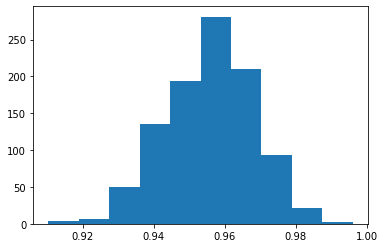

95.0 confidence interval 93.1% and 97.7%


In [73]:
#reconfigure data values for easier bootstrap indexing
vals=df.values
#configure bootstrap
n_iterations = 1000
n_size = int(len(df)*0.8)
#run bootstrap
result_bootstrap = []
predictions = []
test_vals = []
for i in range(n_iterations):
    if i%10==1:
        print(i)
    #prepare train and test sets
    train = resample(vals,n_samples=n_size)
    test = np.array([x for x in vals if x.tolist() not in train.tolist()])
    #fit model
    model = RandomForestClassifier(n_estimators=100)
    model.fit(train[:,2:], train[:,1])
    #evaluate model
    prediction = model.predict(test[:,2:])
    score = model.score(test[:,2:],test[:,1])
    result_bootstrap.append(score)
    predictions.append(prediction)
    test_vals.append(test[:,1])
# plot scores
plt.hist(stats)
plt.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

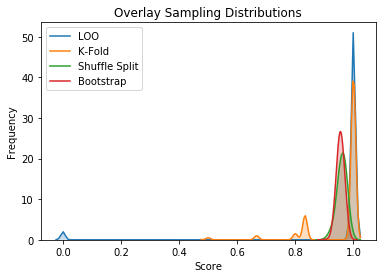

In [75]:
#vizualize everything as gaussians and overlay kde's
#classifier heat maps
#roc curves?
plt.figure()
sea.kdeplot(result_LOO,bw=.008,label="LOO",shade=True)
sea.kdeplot(result_kfold,bw=.008,label="K-Fold",shade=True)
sea.kdeplot(result_shuffsplit,bw=.008,label="Shuffle Split",shade=True)
sea.kdeplot(result_bootstrap,bw=.008,label="Bootstrap",shade=True)
plt.title("Overlay Sampling Distributions")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.savefig("resample_dist_overlays.png",bbox="tight")

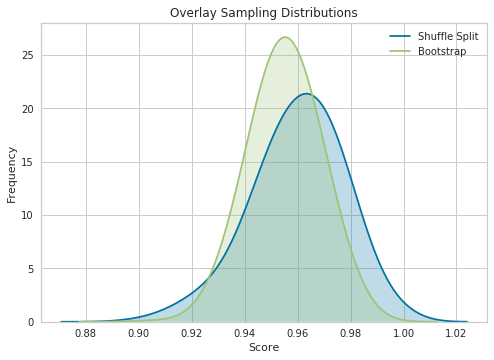

In [147]:
plt.figure()
sea.kdeplot(result_shuffsplit,bw=.008,label="Shuffle Split",shade=True)
sea.kdeplot(result_bootstrap,bw=.008,label="Bootstrap",shade=True)
plt.title("Overlay Sampling Distributions")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.savefig("resample_dist_overlays_just_Shuffsplit_Bootstrap.png",bbox="tight")